In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



df_loan_h3 = pd.read_csv("../data/clean/load_and_clean_loan_data_davy.csv")
df_uci_h3 = pd.read_csv("../data/clean/load_and_clean_uci_data_davy.csv")






In [4]:
df_loan_h3.info()
df_loan_h3.describe()
df_loan_h3.isnull().sum()

<class 'pandas.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_id           255347 non-null  str    
 1   age               255347 non-null  int64  
 2   income            255347 non-null  int64  
 3   loan_amount       255347 non-null  int64  
 4   credit_score      255347 non-null  int64  
 5   months_employed   255347 non-null  int64  
 6   num_credit_lines  255347 non-null  int64  
 7   interest_rate     255347 non-null  float64
 8   loan_term         255347 non-null  int64  
 9   dti_ratio         255347 non-null  float64
 10  education         255347 non-null  str    
 11  employment_type   255347 non-null  str    
 12  marital_status    255347 non-null  str    
 13  has_mortgage      255347 non-null  str    
 14  has_dependents    255347 non-null  str    
 15  loan_purpose      255347 non-null  str    
 16  has_co_signer     255347 non-nu

loan_id             0
age                 0
income              0
loan_amount         0
credit_score        0
months_employed     0
num_credit_lines    0
interest_rate       0
loan_term           0
dti_ratio           0
education           0
employment_type     0
marital_status      0
has_mortgage        0
has_dependents      0
loan_purpose        0
has_co_signer       0
loan_default        0
dtype: int64

In [5]:
df_uci_h3.info()
df_uci_h3.describe()
df_uci_h3.isnull().sum()

<class 'pandas.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            45211 non-null  int64
 1   job_type                       45211 non-null  str  
 2   marital_status                 45211 non-null  str  
 3   education_level                45211 non-null  str  
 4   credit_default                 45211 non-null  str  
 5   account_balance                45211 non-null  int64
 6   housing_loan                   45211 non-null  str  
 7   personal_loan                  45211 non-null  str  
 8   contact_type                   45211 non-null  str  
 9   contact_day                    45211 non-null  int64
 10  contact_month                  45211 non-null  str  
 11  call_duration_sec              45211 non-null  int64
 12  num_contacts_current_campaign  45211 non-null  int64
 13  days_since_last_contact    

age                              0
job_type                         0
marital_status                   0
education_level                  0
credit_default                   0
account_balance                  0
housing_loan                     0
personal_loan                    0
contact_type                     0
contact_day                      0
contact_month                    0
call_duration_sec                0
num_contacts_current_campaign    0
days_since_last_contact          0
num_previous_contacts            0
previous_outcome                 0
subscribed                       0
age_group_bin                    0
campaign_group                   0
contact_missing_flag             0
dtype: int64

###  UCI SEGMENTATION (Behavioural + Demographic)

In [6]:
# Create age segments
df_uci_h3['age_segment'] = pd.cut(
    df_uci_h3['age'],
    bins=[0, 30, 50, 100],
    labels=['Young', 'Middle-aged', 'Senior']
)

In [7]:
# Create balance segments
df_uci_h3['balance_segment'] = pd.cut(
    df_uci_h3['account_balance'],
    bins=[-999999, 0, 500, 2000, 999999],
    labels=['Overdrawn', 'Low', 'Mid', 'High']
)

In [8]:
# Behavioural intensity
df_uci_h3['contact_intensity'] = pd.cut(
    df_uci_h3['num_contacts_current_campaign'],
    bins=[-1, 1, 3, 6, df_uci_h3['num_contacts_current_campaign'].max()], 
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

# -1 to 1 → customers contacted once
# 1 to 3 → light follow-up
# 3 to 6 → moderate
# 6+ → heavy campaign intensity



### UCI DESCRIPTIVE STATISTICS

In [9]:
# Subscription rate by balance segment
df_uci_h3.groupby('balance_segment')['subscribed'].value_counts(normalize=True)

balance_segment  subscribed
Overdrawn        no            0.931044
                 yes           0.068956
Low              no            0.897467
                 yes           0.102533
Mid              no            0.869835
                 yes           0.130165
High             no            0.834255
                 yes           0.165745
Name: proportion, dtype: float64

In [10]:
# Behavioural differences 
df_uci_h3.groupby('balance_segment')[[
    'num_contacts_current_campaign',
    'call_duration_sec',
    'num_previous_contacts'
]].mean()

,num_contacts_current_campaign,call_duration_sec,num_previous_contacts
balance_segment,,,
Overdrawn,2.999863,249.220604,0.399176
Low,2.815197,247.085566,0.535856
Mid,2.646378,266.563664,0.662859
High,2.642983,274.281261,0.694507


In [11]:
# Create a numeric version of  credit default
df_uci_h3['credit_default_num'] = df_uci_h3['credit_default'].map({'yes': 1, 'no': 0})

In [12]:
# Demographic differences
df_uci_h3.groupby('age_segment')[['account_balance', 'credit_default_num']].mean()

,account_balance,credit_default_num
age_segment,,
Young,1019.952774,0.020910
Middle-aged,1286.708014,0.018703
Senior,1858.465478,0.013722


In [13]:
# LOAN SEGMENTATION (Financial + Risk)

In [14]:
# Income segment
df_loan_h3['income_segment'] = pd.qcut(
    df_loan_h3['income'], q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

In [15]:
# Credit score segment
df_loan_h3['credit_segment'] = pd.cut(
    df_loan_h3['credit_score'],
    bins=[0, 580, 670, 740, 850],
    labels=['Poor', 'Fair', 'Good', 'Excellent']
)

In [16]:
# DTI segment
df_loan_h3['dti_segment'] = pd.qcut(
    df_loan_h3['dti_ratio'], q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

In [32]:
uci_summary = df_uci_h3.groupby(
    ['balance_segment', 'age_segment']
).agg({
    'subscribed': lambda x: (x == 'yes').mean(),
    'account_balance': 'mean',
    'num_contacts_current_campaign': 'mean'
}).reset_index()


In [33]:
# Save the segmentation summaries files
uci_summary.to_csv("../dashboards/tableau/uci_segment_summary.csv", index=False)

# LOAN DESCRIPTIVE STATISTICS

In [17]:
# Default rate by income + credit segment
loan_summary = df_loan_h3.groupby(
    ['income_segment', 'credit_segment']
).agg({
    'loan_default': 'mean',
    'loan_amount': 'mean',
    'dti_ratio': 'mean'
}).reset_index()

In [18]:
# Create the loan_to_income feature
df_loan_h3['loan_to_income'] = df_loan_h3['loan_amount'] / df_loan_h3['income']

In [19]:
# Financial features
loan_financial = df_loan_h3[[
    'income', 'loan_amount', 'loan_term', 'interest_rate',
    'loan_to_income', 'dti_ratio', 'credit_score', 'num_credit_lines'
]]

In [20]:
# Behavioural features
loan_behavioural = df_loan_h3[[
    'employment_type', 'marital_status', 'education',
    'has_dependents', 'has_mortgage', 'has_co_signer', 'months_employed'
]]


In [21]:
# Combined features
loan_combined = pd.concat([loan_financial, loan_behavioural], axis=1)

In [22]:
df_loan_h3.columns

Index(['loan_id', 'age', 'income', 'loan_amount', 'credit_score',
       'months_employed', 'num_credit_lines', 'interest_rate', 'loan_term',
       'dti_ratio', 'education', 'employment_type', 'marital_status',
       'has_mortgage', 'has_dependents', 'loan_purpose', 'has_co_signer',
       'loan_default', 'income_segment', 'credit_segment', 'dti_segment',
       'loan_to_income'],
      dtype='str')

In [23]:
loan_combined.columns

Index(['income', 'loan_amount', 'loan_term', 'interest_rate', 'loan_to_income',
       'dti_ratio', 'credit_score', 'num_credit_lines', 'employment_type',
       'marital_status', 'education', 'has_dependents', 'has_mortgage',
       'has_co_signer', 'months_employed'],
      dtype='str')

In [26]:
# segment counts
df_uci_h3['balance_segment'].value_counts()



balance_segment
Low          16385
Mid          13045
High          8501
Overdrawn     7280
Name: count, dtype: int64

In [25]:
df_loan_h3['income_segment'].value_counts()

income_segment
Mid-High    63839
Low         63837
Mid-Low     63837
High        63834
Name: count, dtype: int64

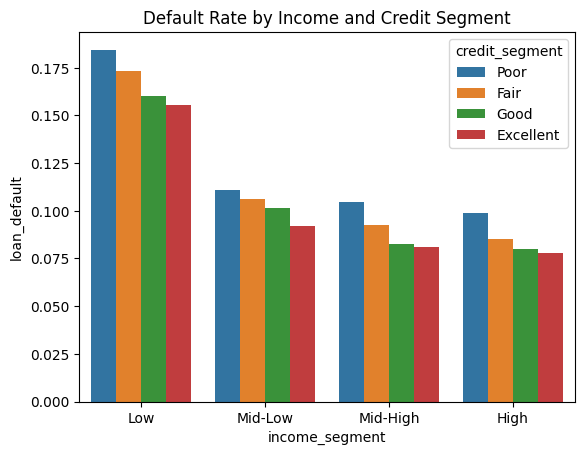

In [27]:
# Visualize segment differences
sns.barplot(data=loan_summary, x='income_segment', y='loan_default', hue='credit_segment')
plt.title("Default Rate by Income and Credit Segment")
plt.show()


In [28]:
df_loan_h3['segment_combo'] = df_loan_h3['income_segment'].astype(str) + "_" + df_loan_h3['credit_segment'].astype(str)


In [29]:
df_uci_h3['segment_combo'] = df_uci_h3['balance_segment'].astype(str) + "_" + df_uci_h3['age_segment'].astype(str)


In [31]:
loan_summary = df_loan_h3.groupby(
    ['income_segment', 'credit_segment']
).agg({
    'loan_default': 'mean',
    'loan_amount': 'mean',
    'dti_ratio': 'mean'
}).reset_index()


In [34]:
# Save the segmentation summaries files
loan_summary.to_csv("../dashboards/tableau/loan_segment_summary.csv", index=False)
